# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

In [1]:
# импортируем нужные библиотеки
import pandas as pd          # инструмент для работы данными 
from pymystem3 import Mystem # для лемматизаци
import seaborn as sns        # для визуализации данных
import numpy as np           # для возможности вызывать математические функции
from collections import Counter # для подсчета количества элементов последовательности        

## Шаг 1. Откройте файл с данными и изучите общую информацию

Cчитаем данные и сохраним под именем df

In [2]:
# используем конструкцию try-except на случай если не получится работать над проектам локально
try:
    df = pd.read_csv('C:/Users/datasets/data.csv')
except:
    df = pd.read_csv('/datasets/data.csv')

Посмотрим сколько и какого типа информацию предстоит обрабатывать. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Видим всего 21525 строк в 12 колонках

В двух колонках есть пропуски

In [4]:
df[{'days_employed','total_income'}].isna().mean() * 100

days_employed    10.099884
total_income     10.099884
dtype: float64

по 10 процентов пропусков в колонках - считаю это много. будем заполнять.

Имена колонок в нормальном виде

In [5]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


In [6]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


значения в некоторых колонках - категорийного типа - им лучше сменить тип с int на str или category 

**Вывод**

И так... в двух колонках есть пропуски. И в этих же колонках надо изменить тип данных. 
Имена значений в колонке образование потребуется привести к строчному виду.
Цели кредита необходимо категоризировать.
Буду изучать данные по каждой колонке отдельно и приводить к нормальному виду.<br>
С именами колонок всё  в порядке.

## Шаг 2. Предоработка данных

#### <b>Колонка children</b> (количество детей)

In [7]:
df['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Видим значение отрицательное - чего не должно быть. Изменим это значение на положительное

In [8]:
df.loc[df['children'] < 0, 'children'] = df.loc[df['children'] < 0, 'children'].abs()

Также наблюдаенм выброс - значение 20 (детей в семье), сильно выходит за рамки других данных в наборе.
Можно изменить на 2, но лучше проверю ...
посмотрим - у людей с каким семейным статусом чаще всего встречается это значение

In [9]:
df[df['children'] == 20]['family_status'].value_counts()

женат / замужем          49
гражданский брак         12
Не женат / не замужем     9
вдовец / вдова            4
в разводе                 2
Name: family_status, dtype: int64

В осносном это сеймейные. Погуглив нашёл статистику по семьям без детей - их доля всего 22 процента от общего числа семей.
Соответсвенно делаю вывод что тут 20 лучше заменить на 2

In [10]:
df.loc[df['children'] == 20, 'children'] = 2
df['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

#### <b>Колонка days_employed</b> (общий трудовой стаж в днях) 


In [11]:
df['days_employed']

0         -8437.673028
1         -4024.803754
2         -5623.422610
3         -4124.747207
4        340266.072047
             ...      
21520     -4529.316663
21521    343937.404131
21522     -2113.346888
21523     -3112.481705
21524     -1984.507589
Name: days_employed, Length: 21525, dtype: float64

Отрицательные значения нужно заменить положительными.

In [12]:
df.loc[df['days_employed'] < 0, 'days_employed'] = df.loc[df['days_employed'] < 0, 'days_employed'].abs()

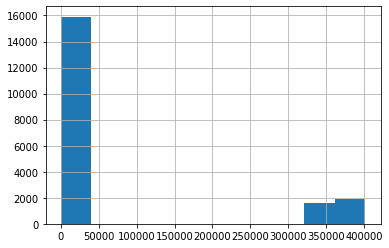

In [13]:
df['days_employed'].hist()

Наблюдаю выброс значений. Посмотри как распределяется стаж по данным без выбросов.

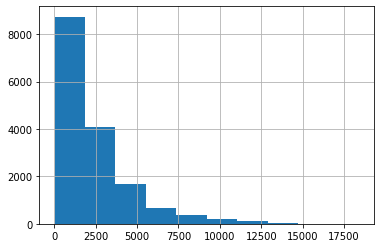

In [14]:
df.loc[df['days_employed'] < 50000,'days_employed'].hist()

У кого значения стажа сильно завышено

In [15]:
df.loc[df['days_employed'] > 20000,'income_type'].value_counts()

пенсионер      3443
безработный       2
Name: income_type, dtype: int64

посмотрим у кого стаж указан нормально

In [16]:
df['days_employed_1'] = df.loc[df['days_employed'] < 20000,'days_employed']
df.groupby('income_type')['days_employed_1'].count()

income_type
безработный            0
в декрете              1
госслужащий         1312
компаньон           4577
пенсионер              0
предприниматель        1
сотрудник          10014
студент                1
Name: days_employed_1, dtype: int64

Получается что у всех пенсионеров значение стажа неверно.
<br>
"Средний трудовой стаж россиян при выходе на пенсию равен 34,5 годам" - заявил статс-секретарь, замминистра труда и соцзащиты Андрей Пудов на заседании в гос думе.<br> 
Это соответствует 12592 дням стажа <br> 
Возможно при введении данных пенсионеров использовался какой-нибудь коэффицент. <br>
Расчитаем на сколько среднее от завышенных данных превышает "Средний трудовой стаж россиян при выходе на пенсию"

In [17]:
df.loc[df['days_employed'] > 20000,'days_employed'].mean().round(2)

365004.31

In [18]:
(365004.31 / 12592)

28.987000476493012

Округлим до 30 - во столько раз стаж у пенсионеров завышен<br>
Применим этот коэффицент как нонижающий к завышенным значениям

In [19]:
df.loc[df['days_employed'] > 20000,'days_employed'] = df.loc[df['days_employed'] > 20000,'days_employed']/30

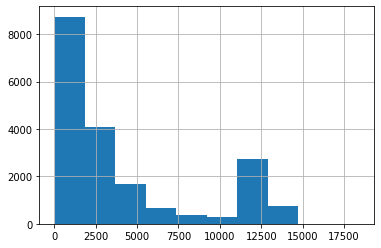

In [20]:
df['days_employed'].hist()

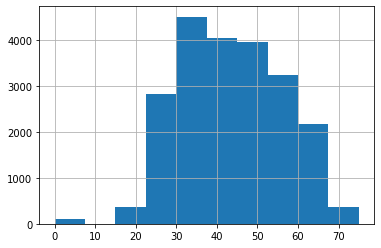

In [21]:
df['dob_years'].hist()

Теперь выбросов нет. Но всё равно распределение стажа совсем не вяжется с распределением возраста...<br>


#### <b> Колонка education.</b> <br>  
Очевидно что имена категорий образования необходимо привести к нормальному виду - сделаем их все прописными буквами.

In [22]:
df['education'] = df['education'].str.lower()
print(df['education'].value_counts())
print(df['education_id'].value_counts())

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64
1    15233
0     5260
2      744
3      282
4        6
Name: education_id, dtype: int64


Отлично - категорий всего 5 и все они соответсвую своим education_id (судя по количеству)

#### <b>Колонка family_status</b>  ( семейный статус )

In [23]:
df['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

Единственное что тут можно поправить - значения 'Не женат / не замужем' сделать полностью строчными.

In [24]:
df['family_status'] = df['family_status'].str.lower()
print(df['family_status'].value_counts())
print(df['family_status_id'].value_counts())

женат / замужем          12380
гражданский брак          4177
не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64
0    12380
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64


категорий всего 5 и все они соответсвую своим family_status_id (судя по количеству)

#### <b>Колонка gender</b>

In [25]:
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

В одном случае пол не определен 

In [26]:
df[df['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_1
10701,0,2358.600502,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости,2358.600502


Что поделать .. это наше будущее. скоро неопределившихся будет [больше](https://www.gazeta.ru/social/2021/10/27/14141647.shtml).
<br>
оставим их в покое


#### <b>Колонка income_type </b>(тип занятости)

In [27]:
df['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

Ничего криминального

#### <b> Колонка debt  </b> (имел ли задолженность)

In [28]:
df['debt'].value_counts()

0    19784
1     1741
Name: debt, dtype: int64

### Обработка пропусков 

#### <b>Колонка days_employed</b> (общий трудовой стаж в днях) 

Во-первых - из info видел что в этой колокнке есть пропуски.<br>
В-третьих - дробные значения в днях нам тут никчему - сделаем целыми.<br>
В-четвертых -  для наглядности считаю что лучше добавить колонку со стажем в годах.(за полный месяц принимается 30 календарных дней, а за год — 12 месяцев)

In [29]:
# посмотрим сколько пропусков в столбце 
df[df['days_employed'].isnull()]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

In [30]:
# посмотрим на значения которыми хочу заполнять пропуски
pd.pivot_table(df, index=['income_type','education','gender'], values='days_employed', aggfunc=np.median)

days_employed
income_type     education           gender               
безработный     высшее              F        13176.761288
                среднее             M        11250.815561
в декрете       среднее             F         3296.759962
госслужащий     высшее              F         2483.577183
                                    M         2835.604975
                начальное           F         2787.767403
                                    M         2477.309991
                неоконченное высшее F         1590.662413
                                    M         2187.572238
                среднее             F         2927.710247
                                    M         2647.283057
                ученая степень      F         5968.075884
компаньон       высшее              F         1537.596096
                                    M         1327.821363
                начальное           F         1151.634460
                                    M         1075.317410
                неоконченное высшее F          953.985197
                                    M         1040.536961
                                    XNA       2358.600502
                среднее             F         1706.131182
                                    M         1606.165635
пенсионер       высшее              F        12230.160355
                                    M        12164.081314
                начальное           F        12091.579449
                                    M        11670.534875
                неоконченное высшее F        12433.864144
                                    M        11979.578853
                среднее             F        12197.713515
                                    M        12058.269424
                ученая степень      F        12542.540651
                                    M        11252.827185
предприниматель высшее              F          520.848083
сотрудник       высшее              F         1635.986278
                                    M         1331.749459
                начальное           F         1452.698328
                                    M         1036.834600
                неоконченное высшее F         1138.644216
                                    M         1241.642451
                среднее             F         1770.271341
                                    M         1383.235092
                ученая степень      M         2351.431934
студент         высшее              M          578.751554

In [31]:
# тут мы перезаписываем пропуски 
# группируем по занятости+образованию+полу и в столбце доход "трансформируем" данные вычисляемым значением 
# медианs в группе хитрой функцией в которой другая фнукция

df['days_employed'] = df.groupby(['income_type','education','gender'])['days_employed'].transform(lambda x: x.fillna(x.median()))

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [32]:
# теперь делаем значения целыми
# но для одной строки с пропуском значение не вычислилось, так как оно оказалось единственной записью в группе 
# сделаем группы по более и возьму теперь среднюю

if df[df['days_employed'].isnull()]['income_type'].count() > 0:   
    df['days_employed'] = df.groupby(['income_type'])['days_employed'].transform(lambda x: x.fillna(x.mean()))
    
df[df['days_employed'].isnull()]['income_type'].count()

0

#### <b> Колонка total_income </b> (ежемесячный доход) 

In [33]:
df.loc[pd.isna(df['total_income'])]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_1
12,0,12058.269424,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу,NaN
26,0,2647.283057,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование,NaN
29,0,12197.713515,63,среднее,1,не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости,NaN
41,0,2927.710247,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем,NaN
55,0,12197.713515,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,1606.165635,47,среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем,NaN
21495,1,1770.271341,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба,NaN
21497,0,1537.596096,48,высшее,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости,NaN
21502,1,1770.271341,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости,NaN


Откуда могли взяться пропуски в данных - это лучше спросить у data engeneer который организовывал работу по сбору данных.
Могу предположить что при заполнении данных о стаже и доходах, заполняющие, вместо нуля указали текстовое 'нет', а система сбора данных не пропустила не числовое значение, и поле данных оставила пустым.

In [34]:
# посмотрим на значения которыми хочу заполнять пропуски
pd.pivot_table(df, index=['income_type','education','gender'], values='total_income', aggfunc=np.median)

total_income
income_type     education           gender               
безработный     высшее              F       202722.511368
                среднее             M        59956.991984
в декрете       среднее             F        53829.130729
госслужащий     высшее              F       157841.438279
                                    M       214706.640963
                начальное           F        89618.962330
                                    M       190966.659534
                неоконченное высшее F       136599.129610
                                    M       177320.628254
                среднее             F       125831.806597
                                    M       169651.956756
                ученая степень      F       111392.231107
компаньон       высшее              F       189893.464621
                                    M       233064.883613
                начальное           F       134012.003567
                                    M       150100.960964
                неоконченное высшее F       170471.622782
                                    M       191291.929274
                                    XNA     203905.157261
                среднее             F       144881.784198
                                    M       181889.020944
пенсионер       высшее              F       142404.278858
                                    M       157457.331331
                начальное           F       101180.566458
                                    M       113124.202781
                неоконченное высшее F       116592.976550
                                    M       124667.471301
                среднее             F       112790.975121
                                    M       126097.196750
                ученая степень      F       255425.196556
                                    M        98752.495442
предприниматель высшее              F       499163.144947
сотрудник       высшее              F       153691.851098
                                    M       192247.298639
                начальное           F       118516.720741
                                    M       141637.960402
                неоконченное высшее F       134925.188145
                                    M       189075.918446
                среднее             F       124127.090016
                                    M       156286.402929
                ученая степень      M       198570.757322
студент         высшее              M        98201.625314

In [35]:
# тут мы перезаписываем пропуски 
# группируем по занятости+образованию+полу и в столбце доход "трансформируем" данные вычисляемым значением 
# медианs в группе хитрой функцией в которой другая фнукция

df['total_income'] = df.groupby(['income_type','education','gender'])['total_income'].transform(lambda x: x.fillna(x.median()))

In [36]:
# но для одной строки с пропуском значение не вычислилось, так как оно оказалось единственной записью в группе 
# сделаем группы по более и возьму теперь среднюю
df['total_income'] = df.groupby(['income_type'])['total_income'].transform(lambda x: x.fillna(x.mean()))
df[df['days_employed'].isnull()]['income_type'].count()

0

#### <b>Колонка - возраст.</b><br> 

Посмотрим есть ли выбросы - то есть возраст меньше 18 и больше 80. Так как заёмщикам с таким возрастом кредитов не дают.

In [37]:
df[(df['dob_years'] <18) | (df['dob_years'] > 80)]['dob_years'].value_counts()

0    101
Name: dob_years, dtype: int64

101 "новорожденный" - кто они ...

In [38]:
df.loc[df['dob_years'] == 0]['income_type'].value_counts()

сотрудник      55
компаньон      20
пенсионер      20
госслужащий     6
Name: income_type, dtype: int64

Хочу посмотреть средний возраст по группам занятости

Буду считать что нулевое значение возраста является пропуском - заполню его средним значением по группам занятости

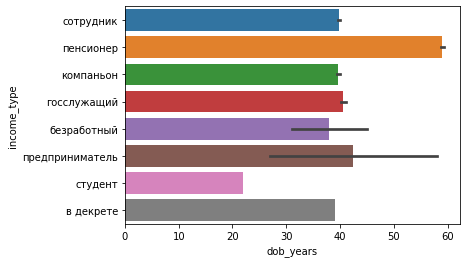

In [39]:
sns.barplot(x="dob_years", y='income_type', data=df)

In [40]:
df.groupby('income_type')['dob_years'].mean()

income_type
безработный        38.000000
в декрете          39.000000
госслужащий        40.636737
компаньон          39.697542
пенсионер          59.063019
предприниматель    42.500000
сотрудник          39.821027
студент            22.000000
Name: dob_years, dtype: float64

Не придумал как это сделать по другому - нули заменим на пропуски, потом пропуски заменим на среднее в группе

In [41]:
df.loc[df['dob_years'] == 0, 'dob_years'] = None

In [42]:
df['dob_years'] = df['dob_years'].fillna(df.groupby('income_type')['dob_years'].transform('mean'))

### Изменение типа 

In [43]:
# меняемт тип на целочисленные в столбцах стаж и доход
df['days_employed'] = df['days_employed'].astype(int)

In [44]:
df['total_income'] = df['total_income'].astype(int)

In [45]:
df['dob_years'] = df['dob_years'].astype(int)

In [46]:
# создаём колокнку стажа в годах (для наглядности)
df['years_employed'] = df['days_employed'] / 365
df['years_employed'] = df['years_employed'].astype(int)
#(df.loc[:,['days_employed','years_employed', 'dob_years']].head())
df[['days_employed','years_employed','dob_years']].head()

,days_employed,years_employed,dob_years
0,8437,23,42
1,4024,11,36
2,5623,15,33
3,4124,11,32
4,11342,31,53


Давайте посмотрим не привышает ли рабочий стаж  возраст 

In [47]:
# фильтр - у скольких людей в выборке стаж превышает возраст
print(df[(df['days_employed']/365) > df['dob_years']]['income_type'].value_counts())

пенсионер    13
Name: income_type, dtype: int64


In [48]:
print('Всего:',df[(df['days_employed']/365) > df['dob_years']]['income_type'].count())

Всего: 13


Информация о стаже не требуется для ответа на целевые вопросы -  пока считаю что этот столбец можно проигнориовать!

**Вывод**

В общем и целом требуемые для ответов на вопросы данные приведены в нормальный вид.

### Обработка дубликатов

In [49]:
# воспользуемся методом поиска дубликактов и выведем их сумму
# в аргументах указываем чтоб искал дубликаты используя все столбцы
# keep='first' -  первое значение из повторяющихся будет считаться уникальным
print(df.duplicated(subset=None, keep='first').sum())


71


Они есть . Посмотрим на них одни глазком.

In [50]:
# сама фукция .duplicated() возвращает столбец с булевыми маркерами 
# с помощью неё можно сделать фильтрацию 
display(df[df.duplicated()].tail(15))


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,days_employed_1,years_employed
19387,0,1537,38,высшее,0,гражданский брак,1,F,компаньон,0,189893,на проведение свадьбы,NaN,4
19559,0,1770,41,среднее,1,женат / замужем,0,F,сотрудник,0,124127,свой автомобиль,NaN,4
19688,0,12197,61,среднее,1,женат / замужем,0,F,пенсионер,0,112790,операции с недвижимостью,NaN,33
19832,0,1770,48,среднее,1,женат / замужем,0,F,сотрудник,0,124127,ремонт жилью,NaN,4
19946,0,1770,57,среднее,1,женат / замужем,0,F,сотрудник,0,124127,сделка с подержанным автомобилем,NaN,4
20116,0,12058,57,среднее,1,гражданский брак,1,M,пенсионер,0,126097,свадьба,NaN,33
20165,0,1770,42,среднее,1,женат / замужем,0,F,сотрудник,0,124127,покупка жилья для семьи,NaN,4
20187,0,12197,65,среднее,1,гражданский брак,1,F,пенсионер,0,112790,сыграть свадьбу,NaN,33
20297,1,1770,23,среднее,1,гражданский брак,1,F,сотрудник,0,124127,сыграть свадьбу,NaN,4
20662,0,1383,58,среднее,1,гражданский брак,1,M,сотрудник,0,156286,на проведение свадьбы,NaN,3


Во думаю удалять ли их ... Тут нет явных дубликатов  - в том смысле что данные абсолютно обезличены, нет персональных идентификаторов. А вероятнолсть что два человека в одном возрасте с одинаковым семейны положением , количеством детей , образованием и целью кредита будут в датасете - есть!
И вот что я ещё заметил - все найденные дубликаты - у людей с нулевым доходом(которые ранее были пропусками).

In [51]:
# отфильтруем дублирующиеся записи в которых доход нулевой   и посмотри на их количество 
print(df.loc[(df.duplicated()) & (df['total_income'] == 0) ]['income_type'].value_counts().sum())

0


А что если проверить на дубликаты датасет без колонки доход и занятость

In [52]:
print(df.duplicated(subset=['children', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'purpose'], keep='first').sum())

3687


**Вывод**

Так... Количество дубликатов увеличилось более чем в 50 раз. Я считаю - это говорит о том что это вовсе не дубликаты, а данные подобраны так что очень много людей с одинаковыми (давольно распространненными) характеристиками фигурируют в датафрейме. Удалять я их не буду.<br><br>
(для галочки)<br>
но если было бы надо  - удалил бы их спомощью drop_duplicates(), без аргументов - всё по умолчанию<br>
и конечно затем надо сделать reset_index() с аргументом drop=True для удаления старых индексов

### Лемматизация

<b> Самое интересное purpose (цель получения кредита) </b>

In [53]:
print(list(df['purpose'].unique()))
# print(df['purpose'].value_counts()) # так можно посмотреть количество записей на каждую цель

['покупка жилья', 'приобретение автомобиля', 'дополнительное образование', 'сыграть свадьбу', 'операции с жильем', 'образование', 'на проведение свадьбы', 'покупка жилья для семьи', 'покупка недвижимости', 'покупка коммерческой недвижимости', 'покупка жилой недвижимости', 'строительство собственной недвижимости', 'недвижимость', 'строительство недвижимости', 'на покупку подержанного автомобиля', 'на покупку своего автомобиля', 'операции с коммерческой недвижимостью', 'строительство жилой недвижимости', 'жилье', 'операции со своей недвижимостью', 'автомобили', 'заняться образованием', 'сделка с подержанным автомобилем', 'получение образования', 'автомобиль', 'свадьба', 'получение дополнительного образования', 'покупка своего жилья', 'операции с недвижимостью', 'получение высшего образования', 'свой автомобиль', 'сделка с автомобилем', 'профильное образование', 'высшее образование', 'покупка жилья для сдачи', 'на покупку автомобиля', 'ремонт жилью', 'заняться высшим образованием']


Явно необходимо добавлять столбец с категориями.
Но сначала надо посмотреть на какие категории разобъём.
Для этого лемматизируем уникальные значения purpose.

In [54]:
# будем использовать библиотеку разработтанную Яндексом

m = Mystem() 
# загрузили библиотеку и теперь получим леммы из столбца purpose

lemmas = []
freq = {}

for item in list(df['purpose'].unique()): # цикл прохода по списку с где записаны сроки с целями кредита
    lemma = m.lemmatize(item)             # получаем из строки список лемм
    if lemma not in lemmas:               # смолтрим чтоб не повторялись записи в списке списков
        lemmas.append(lemma)              # записываем полученный список лемм в список списков лемм
print(*lemmas, sep='\n')


['покупка', ' ', 'жилье', '\n']
['приобретение', ' ', 'автомобиль', '\n']
['дополнительный', ' ', 'образование', '\n']
['сыграть', ' ', 'свадьба', '\n']
['операция', ' ', 'с', ' ', 'жилье', '\n']
['образование', '\n']
['на', ' ', 'проведение', ' ', 'свадьба', '\n']
['покупка', ' ', 'жилье', ' ', 'для', ' ', 'семья', '\n']
['покупка', ' ', 'недвижимость', '\n']
['покупка', ' ', 'коммерческий', ' ', 'недвижимость', '\n']
['покупка', ' ', 'жилой', ' ', 'недвижимость', '\n']
['строительство', ' ', 'собственный', ' ', 'недвижимость', '\n']
['недвижимость', '\n']
['строительство', ' ', 'недвижимость', '\n']
['на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', '\n']
['на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', '\n']
['операция', ' ', 'с', ' ', 'коммерческий', ' ', 'недвижимость', '\n']
['строительство', ' ', 'жилой', ' ', 'недвижимость', '\n']
['жилье', '\n']
['операция', ' ', 'со', ' ', 'свой', ' ', 'недвижимость', '\n']
['автомобиль', '\n']
['заниматься', ' ', 'образование'

**Вывод**

Видно что каждая цель сводятся к определенной сути, которую можно отнести к конкретной категории.
Категории должны быть такими : свадьба, недвижимость, образование, автомобиль.

In [55]:
m = Mystem()

lemmas = m.lemmatize(' '.join(df['purpose']))

Counter(lemmas).most_common()


[(' ', 55201),
 ('недвижимость', 6367),
 ('покупка', 5912),
 ('жилье', 4473),
 ('автомобиль', 4315),
 ('образование', 4022),
 ('с', 2924),
 ('операция', 2610),
 ('свадьба', 2348),
 ('свой', 2235),
 ('на', 2233),
 ('строительство', 1881),
 ('высокий', 1375),
 ('получение', 1316),
 ('коммерческий', 1315),
 ('для', 1294),
 ('жилой', 1233),
 ('сделка', 944),
 ('дополнительный', 909),
 ('заниматься', 908),
 ('подержать', 858),
 ('проведение', 777),
 ('сыграть', 774),
 ('сдача', 653),
 ('семья', 641),
 ('собственный', 635),
 ('со', 630),
 ('ремонт', 612),
 ('приобретение', 462),
 ('профильный', 436),
 ('подержанный', 110),
 ('\n', 1)]

### Категоризация данных

In [56]:
m = Mystem()
def category_purpose(row):
    lem_row = m.lemmatize(row)
    if 'жилье' in lem_row or 'недвижимость' in lem_row:
        return 'недвижимость'
    elif 'автомобиль' in lem_row:
        return 'автомобиль'
    elif 'образование' in lem_row:
        return 'образование'        
    elif 'свадьба' in lem_row:
        return 'свадьба'        
    return 'другое'  
    
df['purpose_category'] = df['purpose'].apply(category_purpose)


In [57]:
print(df['purpose_category'].value_counts())
print()
print('Всего записей в новом столбце:',df['purpose_category'].value_counts().sum())
print('Всего записей в датафрейме:',df['purpose'].count())

недвижимость    10840
автомобиль       4315
образование      4022
свадьба          2348
Name: purpose_category, dtype: int64

Всего записей в новом столбце: 21525
Всего записей в датафрейме: 21525


<b>Проведем категоризацию записей по доходам и категории сохраним в отдельную колонку</b> <br><br>
Думаю лучше будет разбить доход на категории
Федеральная служба государственной статистики разделяет уровень жизни россиян в зависимости от доходов на следующие категории:
- крайняя нищета (доходы ниже прожиточного минимума — до 7-8 тыс.р.)
- нищета (доходы от одного до двух прожиточных минимума — от 8 до 12 тыс.р.)
- бедность (доходы от 12 до 20 тысяч рублей в месяц)
- выше бедности (доходы от 20 до 30 тысяч рублей в месяц)
- средний достаток — (доходы от 30 до 60 тысяч рублей в месяц)
- состоятельные — (доходы от 60 до 90 тысяч рублей в месяц)
- богатые — (доходы от 90 тысяч рублей в месяц)
- сверхбогатые — (доходы свыше 150 тысяч рублей в месяц)
Создадим колонку total_incom_category 

In [58]:
# узнал  тут об одной хорошей функции - которой можно разбить накатегории на скорую руку
df['total_income_category'] = pd.cut(df['total_income'],[8000, 13000, 20000, 30000, 60000, 90000, 150000, 350000])

**Вывод**

Хорошо. Все записи распределились по четырем категриям.

## Шаг 3. Ответьте на вопросы

#### - Есть ли зависимость между наличием детей и возвратом кредита в срок?

Для того что бы увидеть эту зависимость сравним доли "должников" в категориях с детьми и бездетные.

In [59]:
# фильтруем данные получаем количество записей на долдников с детми и без
man_zero_child = df.loc[df['children'] == 0, 'children'].count()
man_with_child = df.loc[df['children'] != 0, 'children'].count()
man_zero_child_debt_1 = df.loc[(df['children'] == 0) & (df['debt'] == 1), 'debt'].count()
man_with_child_debt_1 = df.loc[(df['children'] != 0) & (df['debt'] == 1), 'debt'].count()
proc_man_zero_child_debt_1 = (man_zero_child_debt_1 / man_zero_child) * 100
proc_man_with_child_debt_1 = (man_with_child_debt_1 / man_with_child) * 100
print(f'Всего бездетных: {man_zero_child}. Из них должников {man_zero_child_debt_1}. Доля = {proc_man_zero_child_debt_1:.2f}%')
print(f'Всего с детьми: {man_with_child}. Из них должников {man_with_child_debt_1}. Доля = {proc_man_with_child_debt_1:.2f}%')

Всего бездетных: 14149. Из них должников 1063. Доля = 7.51%
Всего с детьми: 7376. Из них должников 678. Доля = 9.19%


Хочу посмотреть влияет ли количество детей на наличие задолджности
Возьмём всех с детьми и посмотрим как распределяется частота 

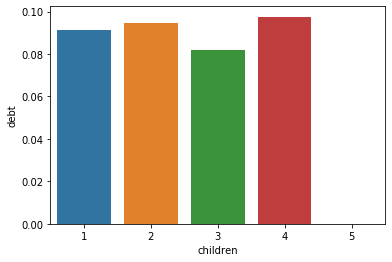

In [60]:

filtered_df = df.loc[(df['children'] != 0)]
sns.barplot(y="debt", x='children', data=filtered_df, ci=None)

<div class="alert alert-info"> <b> </b> 
делаю pivot_table в которой сгрупирую данные по количеству детей и для каждой группы укажу количество всего в группе, должников в группе и их долю 
 </div> <br>

In [61]:
# для вычисления доли сделаем фукцию, которая полуячает серию и отдаёт значение
# def proc_debt(data):
#     return (sum(data)/len(data))*100

pd.pivot_table(df, index='children', values='debt', aggfunc=[len, sum, np.mean]).style.format({('mean', 'debt'):'{:.2%}'})

,len,sum,mean
,debt,debt,debt
children,,,
0,14149,1063,7.51%
1,4865,445,9.15%
2,2131,202,9.48%
3,330,27,8.18%
4,41,4,9.76%
5,9,0,0.00%


Неоднозначный результат - но в общем то видно что с 4 детьми сложнее кредиты возвращать.
Что касается семей с 5 детьми - скорее всего для них выборка слишком мала - таких записей всего 9.

**Вывод**

Наличие детей влияет на 1,68% в сторону увеличения вероятности быть должником.

#### - Есть ли зависимость между семейным положением и возвратом кредита в срок?

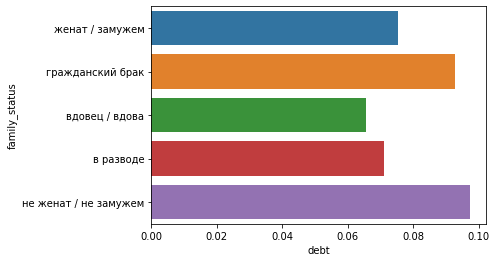

In [62]:
sns.barplot(x="debt", y='family_status', data=df, ci=None)

**Вывод**

У людей в гражданском браке и не женатых/не замужних больше вероятность стать должником

#### - Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [63]:
df['total_income_category'] = pd.cut(df['total_income'], [0, 50000,100000,200000,350000, np.inf])

In [64]:
df.groupby('total_income_category')['debt'].agg(['count','sum', 'mean'])

,count,sum,mean
total_income_category,,,
"(0.0, 50000.0]",372,23,0.061828
"(50000.0, 100000.0]",4093,331,0.080870
"(100000.0, 200000.0]",11915,1026,0.086110
"(200000.0, 350000.0]",4286,306,0.071395
"(350000.0, inf]",859,55,0.064028


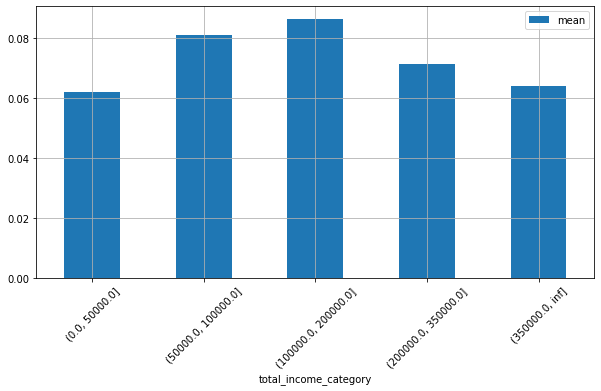

In [65]:
df.groupby('total_income_category')['debt'].agg(['mean']).plot(kind='bar', grid=True, figsize=(10,5), rot=45, ylim=0)

Вот теперь можно делалть выводы

**Вывод**

Зависимость нелинейная - люди с доходом 100000 до 200000 часто становятся должиками...

#### - Как разные цели кредита влияют на его возврат в срок?

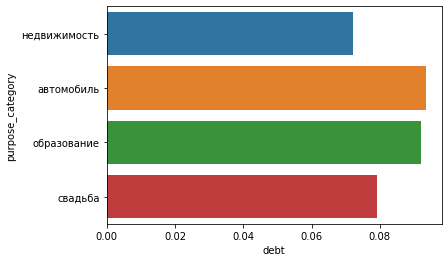

In [66]:
sns.barplot(x="debt", y='purpose_category', data=df, ci=None)

In [67]:
def proc_debt(data):
    return np.mean(data) * 100

pd.pivot_table(df, index='purpose_category', values='debt', aggfunc=[len, sum, proc_debt]).round(2)

,len,sum,proc_debt
,debt,debt,debt
purpose_category,,,
автомобиль,4315,403,9.34
недвижимость,10840,782,7.21
образование,4022,370,9.20
свадьба,2348,186,7.92


Посмотрим как влияет цель кредита по группам дохода

In [68]:
pd.pivot_table(df, index='purpose_category', columns='total_income_category', values='debt',aggfunc=[proc_debt]).round(2)

proc_debt                                           \
total_income_category (0.0, 50000.0] (50000.0, 100000.0] (100000.0, 200000.0]   
purpose_category                                                                
автомобиль                     13.51                7.85                10.15   
недвижимость                    4.47                7.15                 7.60   
образование                     2.47               10.29                 9.66   
свадьба                         7.89                9.09                 8.58   

                                                            
total_income_category (200000.0, 350000.0] (350000.0, inf]  
purpose_category                                            
автомобиль                            8.65            6.67  
недвижимость                          6.73            5.86  
образование                           7.96            6.62  
свадьба                               4.90            8.33

**Вывод**

Как видно из графика кредиты  выданные на неджвижимость дают больше гарантий своевременного возврата.
Тогда как кредит на автомабиль даёт максимальный шанс остаться должником. Автомобили они такие - их заправлять надо.

<b>Дополнительно посмотрим как влияет возраст на возврат кредита.</b>

Согласно последней возрастной классификации ВОЗ, людей по возрастам можно подразделить на следующие категории:<br>
Молодые люди (молодой возраст) — 18-44 года<br>
Люди среднего возраста (средний возраст) — 45-59 лет<br>
Люди пожилого возраста (пожилой возраст) — 60-74 лет<br>
Старые люди (старческий возраст, старость) — 75-90 лет<br>
Долгожители (возраст долголетия) – старше 90 лет<br>

In [69]:

df['dob_years_category'] = pd.cut(df['dob_years'],[0, 25, 35, 45, 60, 75, 100])

pd.pivot_table(df, index='dob_years_category', values='debt', aggfunc=[proc_debt]).round(2)

,proc_debt
,debt
dob_years_category,
"(0, 25]",10.62
"(25, 35]",10.58
"(35, 45]",8.30
"(45, 60]",6.61
"(60, 75]",4.72


С возрастом процент долджников падает.

## Шаг 4. Общий вывод

На данных данных ))  можно делать некоторые ввыводы , но я бы лучше перепроверял на более больших выборках. У меня нет опыта в этом, но надо разбираться вчем причина многих пропусках - ндумаю нельзя допускать такого.

<div class="alert alert-info"> <b> </b> 
Кредитный отдел банка поставил задачу найти некоторые замвисимости в данных по которым можно предсказать вероятность возвранта кредита в срок.
<br>
Для работы предоставлена статистика о платёжеспособности клиентов.
<br>
Результаты исследования будут учтены при построении модели кредитного скоринга.
<br>
Но не ясно в каком виде необходимо выдать результат - процентах или коэфицентах... Это необходимо бы уточнить.
<br>
При узучении общей информации стало ясно что потребуется провести большую работу по предобработке данных, так как в них есть пропуски и артефакты. 
<br>
Команде инженеров занимающихся системами сбора данных необходимо обратить внимание на большое количество пропусков(10%) в данных первостепенной важности - доход! И устранить проблемы. 
<br>
Для выводов на поставленные задачи не требовалась загрузка всех колонок данных, но на всякий случай провел предобработку со всеми данными, что бы в будущем была возможность поискать в них дополнительные "ценности для бизнеса".<br>
<br>
В целом зависимость между наличием детей, семейным положением, уровнем дохода, целью кредита и возвратом кредита в срок - найдена.<br>
Дополнительно определена зависимость между возрастом и возвратом кредита в срок. 
По результатам исследования можно сделать вывод о том что наибольшая вероятность быть должником у незамужнего человека с детьми(хм..) в врозоасте до 35 лет, доходом от 100 до 200 т.р. и целью приобрести автомобиль.

На мой взгляд требуется болеее глубокий анализ данных по различным группам, с привличением дополнительной информации - например суммы ранее выданных кредитов.
    
 </div> <br>